In [1]:

import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import numpy as np, pandas as pd
import random , time, os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import umap

#import for the model
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,Dense,Dropout,BatchNormalization,Input
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

print('TensorFlow version =',tf.__version__)

#import preprocessing

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import log_loss, roc_curve
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


TensorFlow version = 2.3.0


In [2]:
# CONFIGURE GPUs
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.list_physical_devices('GPU'); print(gpus)
if len(gpus)==1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else: strategy = tf.distribute.MirroredStrategy()
    
#Function to convert in tensor
def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg
    
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Preprocess the data with features and embedding with umap

In [3]:
#remove the ctl vehicle with no moa, map type and dose 

def mapping_and_filter(train, train_targets, test):
    cp_type = {'trt_cp': 0, 'ctl_vehicle': 1}
    cp_dose = {'D1': 0, 'D2': 1}
    for df in [train, test]:
        df['cp_type'] = df['cp_type'].map(cp_type)
        df['cp_dose'] = df['cp_dose'].map(cp_dose)
    train_targets = train_targets[train['cp_type'] == 0].reset_index(drop = True)
    train = train[train['cp_type'] == 0].reset_index(drop = True)
    train_targets.drop(['sig_id'], inplace = True, axis = 1)
    train.drop(['sig_id'], inplace = True, axis = 1)
    test.drop(['sig_id'], inplace = True, axis = 1)
    return train, train_targets, test

# Function to scale our data
def scaling(train, test):
    features = train.columns[3:]
    train.columns[3:]
    scaler = StandardScaler()
    scaler.fit(pd.concat([train[features], test[features]], axis = 0))
    train[features] = scaler.transform(train[features])
    test[features] = scaler.transform(test[features])
    return train, test, features


# Function to extract common stats features
def fct_stats(train, test):
    
    features_g = list([col for col in train.columns if col.startswith('g-')])#train.columns[4:140])
    features_c = list([col for col in train.columns if col.startswith('c-')])#train.columns[140:244])
    
    for df in [train, test]:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test


def umap_embedding(train,test):
    
    feat_g = list([col for col in train.columns if col.startswith('g-')])#train.columns[4:140])
    feat_c = list([col for col in train.columns if col.startswith('c-')])#train.columns[140:244])
    
    Umap_g = umap.UMAP(n_neighbors =10, random_state = 34, metric='cosine').fit(train[feat_g])
    Umap_c = umap.UMAP( n_neighbors =10, random_state = 34, metric='cosine').fit(train[feat_c])

    umap_g = pd.DataFrame(Umap_g.embedding_)
    umap_g.columns = ['X_umap_G', 'Y_umap_G']
    umap_c = pd.DataFrame(Umap_c.embedding_)
    umap_c.columns = ['X_umap_C', 'Y_umap_C']
    train = pd.concat([train.reset_index(drop=True), umap_g.reset_index(drop=True), umap_c.reset_index(drop=True)], axis=1, sort=False)

    Uma_g = umap.UMAP(n_neighbors =10, random_state=34, metric='cosine').fit(test[feat_g])
    Uma_c = umap.UMAP(n_neighbors =10, random_state=34, metric='cosine').fit(test[feat_c])                                                
                                                     
    uma_g = pd.DataFrame(Uma_g.embedding_)
    uma_g.columns = ['X_umap_G', 'Y_umap_G']
    uma_c = pd.DataFrame(Uma_c.embedding_)
    uma_c.columns = ['X_umap_C', 'Y_umap_C']
    test = pd.concat([test.reset_index(drop=True), uma_g.reset_index(drop=True), uma_c.reset_index(drop=True)], axis=1, sort=False)
  
    return train,test
    

# Function to calculate the mean log loss of the targets including clipping
def mean_log_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    metrics = []
    for target in range(206):
        metrics.append(log_loss(y_true[:, target], y_pred[:, target]))
    return np.mean(metrics)

#find the weights for initialise the model in using log(TP/TN)
def initiale_weights(train_targets):
    tp = train_targets.sum(axis=0)
    tp = np.array([tp], dtype = np.int)
    res=[]
    for i in tp:
        res=np.around([(i/23814)*100])
    pos = np.count_nonzero(res >= 1)
    neg =np.count_nonzero(res == 0)
    
    initial_bias = np.log([pos/neg])
    
    return initial_bias, neg, pos

In [4]:
# Function to extract pca features
def fe_pca(train, test, n_components_g = 70, n_components_c = 10, SEED = 123):
    
    features_g = list([col for col in train.columns if col.startswith('g-')])
    features_c = list([col for col in train.columns if col.startswith('c-')])
    
    def create_pca(train, test, features, kind = 'g', n_components = n_components_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        pca = PCA(n_components = n_components,  random_state = SEED)
        data = pca.fit_transform(data)
        columns = [f'pca_{kind}{i + 1}' for i in range(n_components)]
        data = pd.DataFrame(data, columns = columns)
        train_ = data.iloc[:train.shape[0]]
        test_ = data.iloc[train.shape[0]:].reset_index(drop = True)
        train = pd.concat([train, train_], axis = 1)
        test = pd.concat([test, test_], axis = 1)
        return train, test
    
    train, test = create_pca(train, test, features_g, kind = 'g', n_components = n_components_g)
    train, test = create_pca(train, test, features_c, kind = 'c', n_components = n_components_c)
    return train, test

In [5]:
Top_feat1 = ['g-139',  'g-26', 'g-149', 'g-744', 'g-735', 'g-532', 'g-571', 'g-311', 'g-52', 'g-50',
            'g-476', 'g-22', 'g-599', 'g-47', 'g-321', 'g-555', 'g-580',  'g-639', 'g-487', 'g-12', 
            'g-718', 'g-439', 'g-15', 'g-635', 'g-765', 'g-356', 'g-759', 'g-253', 'g-235', 'g-72', 'g-570', 
            'g-162', 'g-200', 'g-587',  'g-43', 'g-563', 'g-83', 'g-44', 'g-335', 'g-634', 'g-749', 'g-99', 
            'g-300', 'g-180', 'g-519', 'g-34', 'g-312', 'g-615', 'g-273', 'g-265', 'g-606', 'g-165', 'g-30', 'g-148',
            'g-4', 'g-211', 'g-65', 'g-345', 'g-127', 'g-280', 'g-740', 'g-574', 'g-479', 'g-45', 'g-533', 'g-203', 'g-537',
            'g-194', 'g-761', 'g-156', 'g-651', 'g-750', 'g-309', 'g-590', 'g-9', 'g-531', 'g-432', 'g-81', 'g-208', 
            'g-586', 'g-108', 'g-175', 'g-192', 'g-337', 'g-202', 'g-178', 'g-655', 'g-205', 'g-407', 'g-89', 'g-617',
            'g-706', 'g-69', 'g-161', 'g-79', 'g-3', 'g-627', 'g-282', 'g-252', 'g-260', 'g-437', 'g-610', 'g-576',
            'g-488', 'g-324', 'g-584', 'g-370', 'g-350', 'g-664', 'g-422', 'g-640',  'g-387', 'g-117', 'g-696',
            'g-140', 'g-206', 'g-769', 'g-318', 'g-546', 'g-466', 'g-231', 'g-342', 'g-418', 'g-701', 'g-20', 
            'g-18', 'g-463', 'g-591', 'g-100', 'g-157', 'g-357', 'g-392', 'g-122', 'g-91', 'g-158', 'g-628', 
            'g-90', 'g-763', 'g-351', 'g-322','c-0', 'c-1', 'c-2', 'c-3', 'c-4', 'c-5', 'c-6', 'c-7', 'c-8', 'c-9', 
            'c-10', 'c-11', 'c-12', 'c-13', 'c-14', 'c-15', 'c-16', 'c-17', 'c-18', 'c-19', 'c-20', 'c-21', 'c-22', 
            'c-23', 'c-24', 'c-25', 'c-26', 'c-27', 'c-28', 'c-29', 'c-30', 'c-31', 'c-32', 'c-33', 'c-34', 'c-35', 
            'c-36', 'c-37', 'c-38', 'c-39', 'c-40', 'c-41', 'c-42', 'c-43', 'c-44', 'c-45', 'c-46', 'c-47', 'c-48', 
            'c-49', 'c-50', 'c-51', 'c-52', 'c-53', 'c-54', 'c-55', 'c-56', 'c-57', 'c-58', 'c-59', 'c-60', 'c-61', 
            'c-62', 'c-63', 'c-64', 'c-65', 'c-66', 'c-67', 'c-68', 'c-69', 'c-70', 'c-71', 'c-72', 'c-73', 'c-74', 
            'c-75', 'c-76', 'c-77', 'c-78', 'c-79', 'c-80', 'c-81', 'c-82', 'c-83', 'c-84', 'c-85', 'c-86', 'c-87', 
            'c-88', 'c-89', 'c-90', 'c-91', 'c-92', 'c-93', 'c-94', 'c-95', 'c-96', 'c-97', 'c-98', 'c-99']


In [6]:
Top_feat = ['g-139', 'c-30', 'g-26', 'g-149', 'g-744', 'g-735', 'g-532', 'g-571', 'g-311', 'g-52', 'g-50',
            'g-476', 'g-22', 'g-599', 'g-47', 'g-321', 'g-555', 'g-580', 'c-86', 'g-639', 'g-487', 'g-12', 
            'g-718', 'g-439', 'g-15', 'g-635', 'g-765', 'g-356', 'g-759', 'g-253', 'g-235', 'g-72', 'g-570', 
            'g-162', 'g-200', 'g-587', 'c-46', 'g-43', 'g-563', 'g-83', 'g-44', 'g-335', 'g-634', 'g-749', 'g-99', 
            'g-300', 'g-180', 'g-519', 'g-34', 'g-312', 'g-615', 'g-273', 'g-265', 'g-606', 'g-165', 'g-30', 'g-148',
            'g-4', 'g-211', 'g-65', 'g-345', 'g-127', 'g-280', 'g-740', 'g-574', 'g-479', 'g-45', 'g-533', 'g-203', 'g-537',
            'g-194', 'g-761', 'g-156', 'g-651', 'g-750', 'g-309', 'g-590', 'g-9', 'g-531', 'g-432', 'g-81', 'g-208', 
            'g-586', 'g-108', 'g-175', 'g-192', 'g-337', 'g-202', 'g-178', 'g-655', 'g-205', 'g-407', 'g-89', 'g-617',
            'g-706', 'g-69', 'g-161', 'g-79', 'g-3', 'g-627', 'g-282', 'g-252', 'g-260', 'g-437', 'g-610', 'g-576',
            'g-488', 'g-324', 'g-584', 'g-370', 'g-350', 'g-664', 'g-422', 'g-640', 'c-78', 'g-387', 'g-117', 'g-696',
            'g-140', 'g-206', 'g-769', 'g-318', 'c-98', 'g-546', 'g-466', 'g-231', 'g-342', 'g-418', 'g-701', 'g-20', 
            'c-65', 'g-18', 'g-463', 'g-591', 'g-100', 'g-157', 'g-357', 'g-392', 'g-122', 'g-91', 'g-158', 'g-628', 
            'g-90', 'g-763', 'g-351', 'g-322']

# Define the MODEL:

In [7]:
def build_model_3l(shape):
    
    output_bias = tf.keras.initializers.Constant(-1.65678403)
    model = Sequential([
    Input(shape),
    layers.BatchNormalization(),
    Dropout(0.4),
    Dense(2048, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    Dense(1024, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    Dense(512, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    Dense(206, activation ="sigmoid",bias_initializer = output_bias)])
    
#define otpimizer   
    opt = tf.optimizers.Adam(learning_rate = 0.001)
    #opt = tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10)
    

#define the loss
    #LOSS = tf.keras.losses.categorical_crossentropy( label_smoothing=0.0020)
    LOSS = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015)
    
    model.compile( optimizer= opt, loss= LOSS,metrics= tf.keras.metrics.AUC(name='auc'))
    
    #model.summary()
    
    return model


def build_model_4l(shape):
    
    output_bias = tf.keras.initializers.Constant(-1.65678403)
    model = Sequential([
    Input(shape),
    layers.BatchNormalization(),
    Dropout(0.4),
    Dense(2048, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    Dense(1592, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    Dense(1024, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    Dense(512, activation="elu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    Dense(206, activation ="sigmoid",bias_initializer = output_bias)])
    
#define otpimizer   
    opt = tf.optimizers.Adam(learning_rate = 0.001)
    #opt = tfa.optimizers.Lookahead(tf.optimizers.Adam(), sync_period=10)
    

#define the loss
    #LOSS = tf.keras.losses.categorical_crossentropy( label_smoothing=0.0020)
    LOSS = tf.keras.losses.BinaryCrossentropy(label_smoothing = 0.0015)
    
    model.compile( optimizer= opt, loss= LOSS,metrics= tf.keras.metrics.AUC(name='auc'))
    
    #model.summary()
    
    return model    

# Custom the learning schedule

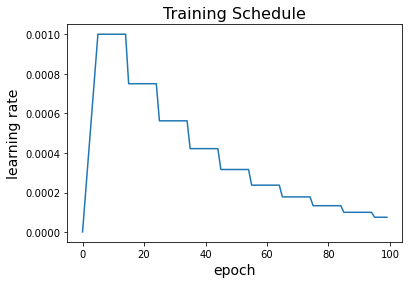

In [8]:
# CUSTOM LEARNING SCHEUDLE
LR_START = 1e-6
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

# Train and evaluate the model:

In [9]:
def train_model(train, test, train_targets,features, FOLDS, SEED ,MODEL):
    
    
    seed_everything(SEED) 
    oof_pred = np.zeros((train.shape[0], 206))
    test_pred = np.zeros((test.shape[0], 206)) 
    
    for fold, (trn_ind, val_ind) in enumerate(MultilabelStratifiedKFold(n_splits = FOLDS, random_state = SEED, 
                                                                        shuffle = True).split(train, train_targets)):
        
        
        print('#'*25)
        print('### FOLD %i' % (fold+1))
        print(f'###Training model {MODEL} with seed {SEED}')
        print('### train on %i data validate on %i data' % (len(trn_ind),len(val_ind)))
        print('#'*25)
    
        x_train, x_test = train[features].values[trn_ind], train[features].values[val_ind]
        y_train, y_test = train_targets.values[trn_ind], train_targets.values[val_ind]
        
        K.clear_session()
        if MODEL == '4l':
            model = build_model_4l(len(features))
        elif MODEL == '3l':
            model = build_model_3l(len(features))
        
        #model = build_model(x_train,y_train, initial_bias)
        
        checkpoint_path = f'Best_weights_Fold:{fold}.hdf5'
        
        #reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=PATIENCE, verbose=VERBOSE, epsilon=1e-4, mode='min')
        
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
        #                                                    mode = 'min',
        #                                                    patience = PATIENCE,
        #                                                    restore_best_weights = True,
        #                                                    verbose = VERBOSE)
        
        model_checkpt = ModelCheckpoint(checkpoint_path, monitor = 'val_loss', verbose = 2, save_best_only = True,
                                         save_weights_only = True, mode = 'min')   
    
        
        history = model.fit( x_train, y_train,
                    validation_data= (x_test, y_test),
                    verbose= 2, 
                    epochs= EPOCHS, 
                    batch_size= 128,
                    callbacks = [ lr2, model_checkpt ])
        
        model.load_weights(checkpoint_path)
        oof_pred[val_ind] = model.predict(x_test, batch_size = 128)
        test_pred += model.predict(test[features].values) / FOLDS
        
    oof_score = mean_log_loss(train_targets.values, oof_pred)
    print(f'FOLD mean log loss score is {oof_score}')
    
    return test_pred, oof_pred, history

In [10]:
# Function to train our model with multiple seeds and average the predictions
def run_multiple_seeds(train, test, train_targets, FOLDS, SEEDS = [12], MODEL = '4l'):
    
    test1_pred = []
    oof1_pred = []
    
    for SEED in SEEDS:
        print(f'Training model {MODEL} with seed {SEED}')
        train_, test_ = fe_pca(train, test, n_components_g = 70, n_components_c = 10, SEED = SEED)
        train_, test_, features = scaling(train_, test_)
        #print(f'Training with {len(features)} features')
        test_pred_, oof_pred_ = train_model(train_, test_, train_targets,features, FOLDS, SEED = SEED, MODEL = MODEL)
        test1_pred.append(test_pred_)
        oof1_pred.append(oof_pred_)
        print('-'*50)
        print('\n')
        
    test1_pred = np.average(test1_pred, axis = 0)
    oof1_pred = np.average(oof1_pred, axis = 0)
        
    seed_log_loss = mean_log_loss(train_targets.values, oof1_pred)
    print(f'Our out of folds log loss for our seed blend model is {seed_log_loss}')
    
    return test1_pred, oof1_pred

# initialyse the initial weight and train the model

In [11]:
FOLDS = 5
EPOCHS = 35
#BatchSize = 128
#VERBOSE = 2
#SEEDS = 34
SEEDS2 =  34 
SEEDS3 =  42
PATIENCE = 10

start_time = time.time()

#read the data and process them:
train1 = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')
test1 = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')


#trn = pd.concat([train1.iloc[:,:4],train1[Top_feat]],  axis=1 )
#test01 = pd.concat([test1.iloc[:,:4],test1[Top_feat]],  axis=1 )

train01, train_targets, test12 = mapping_and_filter(train1, train_targets_scored, test1)

#train, test = umap_embedding(train,test)
#train, test = fe_pca(train01, test12, n_components_g = 70, n_components_c = 10, SEED = SEEDS)
trn, tst = fct_stats(train01, test12)
#train, test, features = scaling(train, test)

#find the weight for initialise the model in using log(TP/TN)

initial_bias, neg, pos = initiale_weights(train_targets)
print('Targets Tp:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format((neg + pos), pos, 100 * pos / (neg + pos)))


#print('#'*25)
#print('#'*25)
print('Weights initial biais:', initial_bias )
#print("Training set:",train.shape)
#print("labels:",train_targets.shape)
#print("test:",test.shape)
#print("Features:", features.shape)
#print("submission:",sample_submission.shape)

#train the model
#test_pred, oof_pred, history = train_model(train, train_targets, test, features, FOLDS, SEEDS, PATIENCE, VERBOSE, initial_bias)
train41, test41 = fe_pca(trn, tst, n_components_g = 70, n_components_c = 10, SEED = SEEDS2)
train41, test41, features41 = scaling(train41, test41)

test_pred_4l, oof_pred_4l, history1 = train_model(train41, test41, train_targets, features41, FOLDS, SEED = SEEDS2, MODEL = '4l')

train31, test31 = fe_pca(trn, tst, n_components_g = 70, n_components_c = 10, SEED = SEEDS3)
train31, test31, features31 = scaling(train31, test31)

test_pred_3l, oof_pred_3l, history2 = train_model(train31, test31, train_targets, features31, FOLDS, SEED = SEEDS3, MODEL = '3l')

oof_pred = np.average([oof_pred_4l, oof_pred_3l], axis = 0)
seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
print(f'Our final out of folds log loss for our blended models is {seed_log_loss}')

test_pred = np.average([test_pred_4l, test_pred_3l], axis = 0)

print('#'*25)
print('#'*25)
print("--- %s minutes ---" % ((time.time() - start_time)/60))

Targets Tp:
    Total: 206
    Positive: 33 (16.02% of total)

Weights initial biais: [-1.65678403]
#########################
### FOLD 1
###Training model 4l with seed 34
### train on 17558 data validate on 4390 data
#########################

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-06.
Epoch 1/35

Epoch 00001: val_loss improved from inf to 0.20788, saving model to Best_weights_Fold:0.hdf5
138/138 - 2s - loss: 0.3712 - auc: 0.4972 - val_loss: 0.2079 - val_auc: 0.5355

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00020080000000000003.
Epoch 2/35

Epoch 00002: val_loss improved from 0.20788 to 0.19805, saving model to Best_weights_Fold:0.hdf5
138/138 - 1s - loss: 0.2813 - auc: 0.5527 - val_loss: 0.1981 - val_auc: 0.6225

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0004006000000000001.
Epoch 3/35

Epoch 00003: val_loss improved from 0.19805 to 0.10628, saving model to Best_weights_Fold:0.hdf5
138/138 - 1s - loss: 0.1774 - auc: 0

# Plot the LOSS and AUC curves

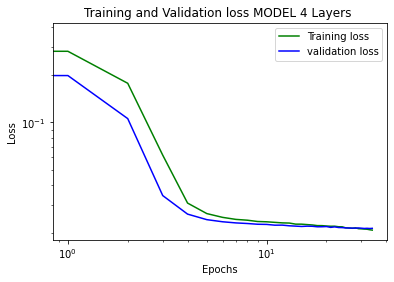

In [12]:

plt.loglog([i for i in range(EPOCHS)], history1.history['loss'], 'g', label='Training loss')
plt.loglog([i for i in range(EPOCHS)], history1.history['val_loss'], 'b', label='validation loss')
   
plt.title('Training and Validation loss MODEL 4 Layers ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

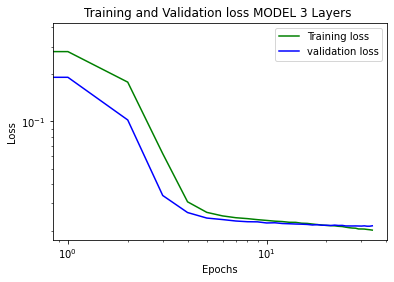

In [13]:
plt.loglog([i for i in range(EPOCHS)], history2.history['loss'], 'g', label='Training loss')
plt.loglog([i for i in range(EPOCHS)], history2.history['val_loss'], 'b', label='validation loss')
   
plt.title('Training and Validation loss MODEL 3 Layers ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

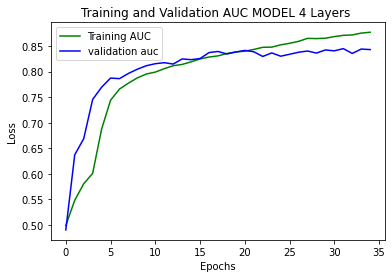

In [14]:
plt.plot([i for i in range(EPOCHS)], history1.history['auc'], 'g', label='Training AUC')
plt.plot([i for i in range(EPOCHS)], history1.history['val_auc'], 'b', label='validation auc')
   
plt.title('Training and Validation AUC MODEL 4 Layers ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

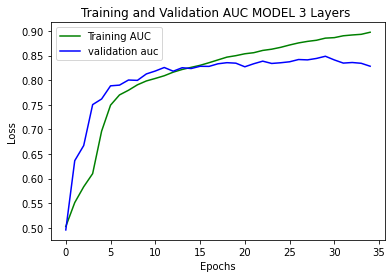

In [15]:
plt.plot([i for i in range(EPOCHS)], history2.history['auc'], 'g', label='Training AUC')
plt.plot([i for i in range(EPOCHS)], history2.history['val_auc'], 'b', label='validation auc')
   
plt.title('Training and Validation AUC MODEL 3 Layers ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
seed_log_loss = mean_log_loss(train_targets.values, oof_pred)
print(f'Final out of folds log loss for the models is {seed_log_loss}')

Final out of folds log loss for the models is 0.016067033921788987


# Submit predictions

In [17]:
def submission(test_pred):
    sample_submission.loc[:, train_targets.columns] = test_pred
    sample_submission.loc[tst['cp_type'] == 1, train_targets.columns] = 0
    sample_submission.to_csv('submission.csv', index = False)
    return sample_submission


In [18]:
sample_submission = submission(test_pred)
sample_submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001083,0.002119,0.002079,0.017914,0.024001,0.004732,0.002010,0.006878,0.000313,...,0.001158,0.002418,0.003063,0.000914,0.000610,0.001268,0.000839,0.001868,0.006079,0.001936
1,id_001897cda,0.000391,0.001619,0.001543,0.001404,0.002403,0.003995,0.003875,0.012590,0.015863,...,0.001273,0.001160,0.002720,0.000171,0.010493,0.001161,0.008219,0.000842,0.003940,0.002193
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000912,0.001213,0.002378,0.010392,0.009411,0.004476,0.002312,0.004571,0.000449,...,0.001018,0.001010,0.003164,0.022920,0.006974,0.000881,0.001325,0.002155,0.001423,0.004243
4,id_0027f1083,0.003248,0.002233,0.002205,0.018023,0.023945,0.003975,0.006376,0.002076,0.000510,...,0.001372,0.000865,0.004631,0.002990,0.001211,0.001075,0.001401,0.002041,0.000359,0.001882
